# Uso de Rockstar

### Cargamos las bibliotecas que necesitamos

In [1]:
import glob
import math
import sys
import os

import pandas as pd
import numpy as np
import numpy


#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('classic')
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from IPython.display import display

from scipy import interpolate

### Catálogo de halos padre

In [2]:
Np    = 1024           #cube root of the number of particles
Npart = Np**3
Lbox  = 500.           #length of the box

Mpart = 9.86379e+09    #mass of each particle (in M_sun/h units)
Mmax  = 3.6e+15        #max Mass (used to define the mass bins)

#snapshot directories (z:number_of_folder)
z_dict   = {49:1, 2:2, 1.5:3, 1:4, 0.8:5, 0.57:6, 0.5:7, 0.4:8, 0.2:9, 0.1:10, 0:11}
z_snap = 0                       #snapshot to be analised
dir_snap = z_dict.get(z_snap)

#Labels of the columns of the data frames. First we assign preliminary labels 'col'; then we select specific 
#columns and assign the definitive labels listed in cat_labels
cnames = []
for i in range(1,35):
    cnames.append('col'+str(i))

#The columns we select are 
# M200c : 3rd
# R200c : 6th
# Rs    : 7th
# X     : 9th
# Y     : 10th
# Z     : 11th
# PID   : 34th
cat_labels = ['M200c [Msun/h]','R200c [kpc/h]','Rs [kpc/h]','X [Mpc/h]','Y [Mpc/h]','Z [Mpc/h]','PID']

#dataframes with the ROCKSTAR catalogs
print 'Analysing snapshot: z = ', z_snap

lcdm_path = '/home/ealmaraz/software/rockstar/lcdm/bfbdev3/part1024_lbox500/r_00001'       

print 'LCDM - File to be analised: '
if dir_snap < 10:
    fname = lcdm_path+'/output_0000'+str(dir_snap)+'/parents.dat'
    print fname
else:
    fname = lcdm_path+'/output_000'+str(dir_snap)+'/parents.dat'
    print fname

#We import the data and remove the headers       
lcdm_cat = pd.read_table(fname,sep="\s+",skiprows=14)
#We reset the index of the data frames  
lcdm_cat = lcdm_cat.reset_index()    
#We assign the provisional labels to the columns
lcdm_cat.columns=cnames
#We select the columns of our interest and assign the definitive labels
lcdm_cat = lcdm_cat[['col3','col6','col7','col9','col10','col11','col34']]
lcdm_cat.columns = cat_labels
#We get rid of the subhaloes (the parent haloes have PID = -1)
lcdm_cat = lcdm_cat[lcdm_cat['PID']== -1]

#This is the number of parent haloes found in the catalogs
print 'The dataset has {} parent haloes'.format(len(lcdm_cat))    
                               
lcdm_cat.head()

Analysing snapshot: z =  0
LCDM - File to be analised: 
/home/ealmaraz/software/rockstar/lcdm/bfbdev3/part1024_lbox500/r_00001/output_00011/parents.dat
The dataset has 1880378 parent haloes


,M200c [Msun/h],R200c [kpc/h],Rs [kpc/h],X [Mpc/h],Y [Mpc/h],Z [Mpc/h],PID
0,2.367000e+11,100.466,10.102,12.37477,4.60614,8.39578,-1
1,1.973000e+10,43.882,2.877,6.06610,2.25797,14.46326,-1
2,1.874000e+11,92.939,17.668,6.98714,7.69678,15.00067,-1
3,1.213000e+12,173.214,24.962,10.88314,5.52775,11.33124,-1
4,2.269000e+11,99.051,18.873,14.23499,3.46547,13.19376,-1


### i) Cálculo de la función de masa (acumulada) de halos $$n(>M)$$

In [3]:
Np_halo_min = 100.          #minimum number of particles per halo 

#Here we select the haloes whose number of particles are >= Np_halo_min
nltM_cat = lcdm_cat.copy()
nltM_cat = nltM_cat[nltM_cat['M200c [Msun/h]']/Mpart >= Np_halo_min]

#Here we define the center of the bins (uniform spacing in log10 M) stored in logM
nbins = 15                              #number of bins in the M axis
fp    = math.log10(Np_halo_min*Mpart)   #lower bound of the first bin: effective resolution in M
lp    = math.log10(Mmax)                #upper bound of the last bin
ebins = np.linspace(fp,lp,num=nbins+1,endpoint=True)
dbin  = (lp-fp)/nbins                   #bin width
logM  = np.zeros(nbins)
for i in range(0,nbins):
    logM[i]=(fp+dbin/2)+i*dbin              
                   
wbin = range(1,nbins+1)                 #this label tell us to which bin one halo belongs to

nltM_counts = {}             
nltM_counts[0] = logM

#Here we make the bin partition, that is, we determine the number of counts in each bin
nltM_cat['log_10(M200c)'] = nltM_cat['M200c [Msun/h]'].apply(np.log10)
nltM_cat['bin range'] = pd.cut(nltM_cat['log_10(M200c)'],ebins)
nltM_cat['which bin'] = pd.cut(nltM_cat['log_10(M200c)'],ebins,labels=wbin)     
nltM_counts[1]=pd.value_counts(nltM_cat['which bin'],sort=False).values   

     
#Here we colect all the info and construct the data frames
nltM_counts_df = pd.DataFrame(data=nltM_counts)
nltM_counts_df.columns=['log_10(M200c)','counts'] 

#Truncamos el data frame a partir del primer renglon en donde no encontramos halos
for i in range (0,nbins):
    if nltM_counts_df['counts'][i] == 0:
        break 
nltM_counts_df = nltM_counts_df.truncate(after=i-1)

#Once we have the number of counts for each logM bin the calculation of n(>M) is straightforward. 
#First we reverse the order of the elements of nltM_counts_df arrays. Then we calculate the cumulative sum. Note that the 
#value of the cumulative sum for the i-th bin not only takes into account the number of counts of the previous bins but 
#also it includes the number of counts of the i-th bin itself. Finally we reverse once again the order of the arrays and 
#divide everything by the volume of the box
cum = np.flipud(nltM_counts_df.ix[:,1]);   cum = np.cumsum(cum);    cum = np.flipud(cum)
nltM_counts_df['n(>M)'] = cum/(Lbox**3)

#This is the number of haloes we are analysing
print 'We are analysing {} parent haloes'.format(cum[0])    
    
display(nltM_counts_df)  

We are analysing 416171 parent haloes


,log_10(M200c),counts,n(>M)
0,12.112786,156248,3.329368e-03
1,12.350270,100719,2.079384e-03
2,12.587754,63949,1.273632e-03
3,12.825238,40176,7.620400e-04
4,13.062721,23948,4.406320e-04
5,13.300205,14340,2.490480e-04
6,13.537689,8192,1.343280e-04
7,13.775173,4566,6.879200e-05
8,14.012657,2309,3.226400e-05
9,14.250141,1064,1.379200e-05


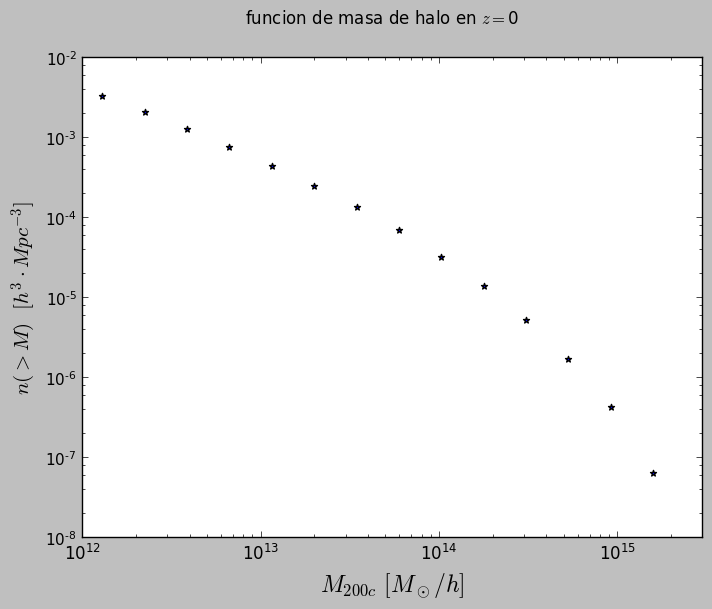

In [4]:
fig = plt.figure()
fig.suptitle('funcion de masa de halo en $z=$'+str(z_snap),fontsize=12)

plt.scatter(10**nltM_counts_df['log_10(M200c)'],nltM_counts_df['n(>M)'],c='blue',marker='*')

plt.xlabel('$M_{200c}$ $[M_\odot/h]$',fontsize=17)
plt.xscale('log')
plt.xlim([1.e12,3e15])

plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)
plt.ylim([1.e-8,1.e-2])
plt.yticks(fontsize=11)
plt.yscale('log')

### ii) Cálculo del parámetro de concentración $$c_{200} = \frac{R_{200}}{R_s}$$

In [5]:
Np_halo_min = 1000.          #minimum number of particles per halo 

#Here we select the haloes whose number of particles are >= Np_halo_min
c200_cat = lcdm_cat.copy()
c200_cat = c200_cat[c200_cat['M200c [Msun/h]']/Mpart >= Np_halo_min]
c200_cat['c200'] = c200_cat['R200c [kpc/h]']/c200_cat['Rs [kpc/h]']                              


#Here we define the center of the bins (uniform spacing in log10 M) stored in logM
nbins = 10                              #number of bins in the M axis
fp    = math.log10(Np_halo_min*Mpart)   #lower bound of the first bin: effective resolution in M
lp    = math.log10(Mmax)                #upper bound of the last bin
ebins = np.linspace(fp,lp,num=nbins+1,endpoint=True)
dbin  = (lp-fp)/nbins                   #bin width
logM  = np.zeros(nbins)
for i in range(0,nbins):
    logM[i]=(fp+dbin/2)+i*dbin              
                   
wbin = range(1,nbins+1)                 #this label tell us to which bin one halo belongs to

c200_counts = {}             
c200_counts[0] = logM

#Here we make the bin partition, that is, we determine the number of counts in each bin
c200_cat['log_10(M200c)'] = c200_cat['M200c [Msun/h]'].apply(np.log10)
c200_cat['bin range'] = pd.cut(c200_cat['log_10(M200c)'],ebins)
c200_cat['which bin'] = pd.cut(c200_cat['log_10(M200c)'],ebins,labels=wbin)  
c200_counts[1]=pd.value_counts(c200_cat['which bin'],sort=False).values   
c200_counts[2]=c200_cat.groupby('which bin').mean()['c200'].values


#Here we colect all the info and construct the data frames
c200_counts_df = pd.DataFrame(data=c200_counts)
c200_counts_df.columns=['log_10(M200c)','counts','c200'] 

#Truncamos el data frame a partir del primer renglon en donde no encontramos halos
for i in range (0,nbins):
    if c200_counts_df['counts'][i] == 0:
        break 
c200_counts_df = c200_counts_df.truncate(after=i-1)

#This is the number of haloes we are analysing
total_haloes = np.cumsum(c200_counts_df['counts']).iloc[-1]                        
print 'We are analysing {} haloes'.format(total_haloes)    
                        
display(c200_counts_df)

We are analysing 48980 haloes


,log_10(M200c),counts,c200
0,13.122157,22815,5.750011
1,13.378383,12938,5.407158
2,13.634608,7022,5.093080
3,13.890834,3575,4.815726
4,14.147060,1660,4.544961
5,14.403286,651,4.182110
6,14.659512,244,4.074585
7,14.915738,67,3.649446
8,15.171964,8,3.542797


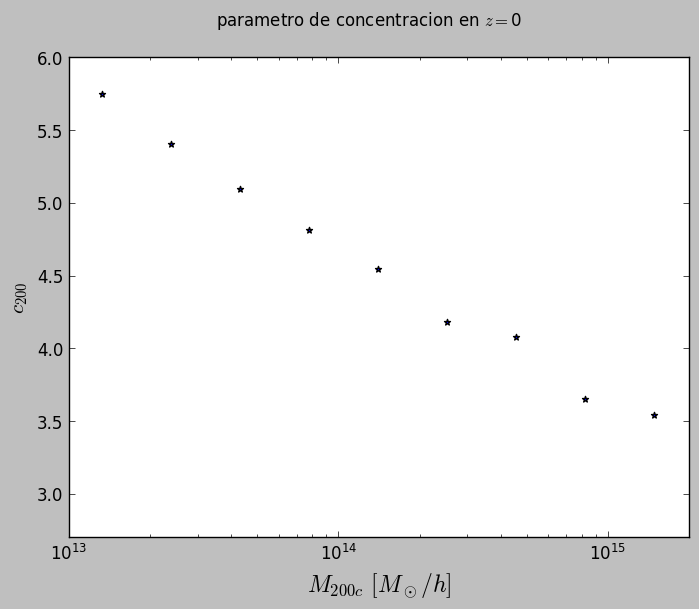

In [6]:
fig = plt.figure()

fig.suptitle('parametro de concentracion en $z=$'+str(z_snap),fontsize=12)
plt.scatter(10**c200_counts_df['log_10(M200c)'],c200_counts_df['c200'],c='blue',marker='*')

plt.xlabel('$M_{200c}$ $[M_\odot/h]$',fontsize=17)
plt.xlim([1.e13,2.e15])
plt.xscale('log')

plt.ylim([2.7,6.])
plt.ylabel('$c_{200}$',fontsize=15)